In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *


In [3]:
#Carregar arquivo de tempo x distância
data = pd.read_excel(r'.\xls\tempodist.xls', sheet_name='Plan2')
data

,Tempo (Y),Distância (X)
0,15,8
1,20,6
2,20,15
3,40,20
4,50,25
5,25,11
6,10,5
7,55,32
8,35,28
9,30,20


In [4]:
#Estatística univariadas
data[['Tempo (Y)', 'Distância (X)']].describe()


,Tempo (Y),Distância (X)
count,10.00000,10.000000
mean,30.00000,17.000000
std,14.90712,9.510228
min,10.00000,5.000000
25%,20.00000,8.750000
50%,27.50000,17.500000
75%,38.75000,23.750000
max,55.00000,32.000000


Criando um objecto para calcular a regressão linear

Equação da Reta: $y = A + Bx$

coeficiênte angular (B): $$B = \frac{n\sum x_{i}y_{i} - \sum x_{i} \sum y_{i}}{n \sum x_{i}^{2} - (\sum x_{i}^{2})}$$

coeficiênte linear (A): $$A = \frac{\sum y - B . \sum x}{n}$$

coeficiênte de correlação:

$$ r_{x,y} = \frac{n \sum x_{i} y_{i} - \sum x_{i} \sum y_{i}}{\sqrt{n \sum x_{i}^{2} - (\sum x_{i})^{2}} \sqrt{n \sum y_{i}^{2} - (\sum y_{i})^{2}}}$$


In [45]:
class RegressaoLinear():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.count = x.count()

        self.matriz = pd.DataFrame()
        self.matriz['x'] = self.x
        self.matriz['y'] = self.y
        self.matriz['x²'] = self.x ** 2
        self.matriz['y²'] = self.y ** 2
        self.matriz['xy'] = self.y * self.x
        self.coefB = 0
        self.coefA = 0
        self.yhat = []
        self.reta()
    
    def coefAngular(self):
        
        self.coefB = (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/ (self.count * self.matriz['x²'].sum()  - (self.matriz['x'].sum())**2)

        return self.coefB
    
    def coefLinear(self):
        self.coefA = (self.matriz['y'].sum() - self.coefA * self.matriz['x'].sum())/ self.count
        return self.coefA
    
    def coefCorr(self):
    
        self.rxy = (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/(sqrt(self.count * self.matriz['x²'].sum() - (self.matriz['x'].sum())**2) * sqrt(self.count * self.matriz['y²'].sum() - (self.matriz['y'].sum()) ** 2))
        return self.rxy
    
    def reta(self):
        self.matriz['yhat'] = self.coefLinear() + self.coefAngular() * self.matriz['x']
        return self.matriz.iloc[:, [0,1, 5]]
    


rlm = RegressaoLinear(data['Distância (X)'], data['Tempo (Y)'])

rlm.matriz       

,x,y,x²,y²,xy,yhat
0,8,15,64,225,120,41.351351
1,6,20,36,400,120,38.513514
2,15,20,225,400,300,51.283784
3,20,40,400,1600,800,58.378378
4,25,50,625,2500,1250,65.472973
5,11,25,121,625,275,45.608108
6,5,10,25,100,50,37.094595
7,32,55,1024,3025,1760,75.405405
8,28,35,784,1225,980,69.729730
9,20,30,400,900,600,58.378378


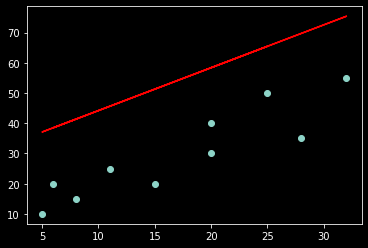

In [46]:
plt.scatter(x = rlm.matriz['x'], y = rlm.matriz['y'])
plt.plot(rlm.matriz['x'], rlm.matriz['yhat'], color = 'red')